In [1]:
!pip install -r ../requirements.txt

In [4]:
import osmnx as ox
import geopandas as gpd
import pandas as pd
import gzip
import shutil
import os
from shapely.geometry import Point
from shapely.geometry import Polygon
import time
import logging
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings("ignore")

### Load the data

In [6]:

start_time = time.time()

file_name = "sr_hex.csv.gz"
var_name = "df_sr_hex"
base_url = "https://cct-ds-code-challenge-input-data.s3.af-south-1.amazonaws.com/"
url = base_url + file_name

print(f"Processing {file_name}...")
!wget -q {url}

# Unzip and load
csv_name = file_name[:-3]  # Remove .gz
with gzip.open(file_name, 'rb') as f_in:
    with open(csv_name, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

os.remove(file_name)  # Optional: clean up compressed file

df = pd.read_csv(csv_name)

print(f"Loaded {file_name} in {time.time() - start_time:.2f} seconds")

Processing sr_hex.csv.gz...


Loaded sr_hex.csv.gz in 6.88 seconds


#### A Quick Look at the Data

In [7]:
df.head().T

,0,1,2,3,4
notification_number,400583534,400555043,400589145,400538915,400568554
reference_number,9109491785.0,9108995239.0,9109614461.0,9108601346.0,NaN
creation_timestamp,2020-10-07 06:55:18+02:00,2020-07-09 16:08:13+02:00,2020-10-27 10:21:59+02:00,2020-03-19 06:36:06+02:00,2020-08-25 09:48:42+02:00
completion_timestamp,2020-10-08 15:36:35+02:00,2020-07-14 14:27:01+02:00,2020-10-28 17:48:15+02:00,2021-03-29 20:34:19+02:00,2020-08-31 08:41:13+02:00
directorate,URBAN MOBILITY,URBAN MOBILITY,URBAN MOBILITY,URBAN MOBILITY,URBAN MOBILITY
department,Roads Infrastructure Management,Roads Infrastructure Management,Roads Infrastructure Management,Roads Infrastructure Management,Roads Infrastructure Management
branch,RIM Area Central,RIM Area East,RIM Area East,RIM Area North,RIM Area South
section,District: Blaauwberg,District : Somerset West,District : Somerset West,District : Bellville,District : Athlone
code_group,TD Customer complaint groups,TD Customer complaint groups,TD Customer complaint groups,TD Customer complaint groups,TD Customer complaint groups
code,Pothole&Defect Road Foot Bic Way/Kerbs,Manhole Cover/Gully Grid,Manhole Cover/Gully Grid,Paint Markings Lines&Signs,Pothole&Defect Road Foot Bic Way/Kerbs


### Get an Overview of the data

In [8]:
print("Dataset Info:")
df.info()
print("\nMissing values:")
print(df.isna().mean().sort_values(ascending=False))

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 941634 entries, 0 to 941633
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   notification_number   941634 non-null  int64  
 1   reference_number      592920 non-null  float64
 2   creation_timestamp    941634 non-null  object 
 3   completion_timestamp  929442 non-null  object 
 4   directorate           932199 non-null  object 
 5   department            932180 non-null  object 
 6   branch                913233 non-null  object 
 7   section               848509 non-null  object 
 8   code_group            941634 non-null  object 
 9   code                  941634 non-null  object 
 10  cause_code_group      131117 non-null  object 
 11  cause_code            129669 non-null  object 
 12  official_suburb       729221 non-null  object 
 13  latitude              729270 non-null  float64
 14  longitude             729270 non-null 

- many features have missing values not sure if it actually matters
- according to the documentation, missing h3_level8_index values were set to '0'
- there are 22.5% latitude and longitudes that are missing - this means that there are also 22.5% h3_level8_index missing. Quite high but will have to drop these rows as without h3_level8_index the rows are of no value.
- cause_code and cause_code_group both have 86% missing values - won't use these features
- code and code_group have zero missing values.  Let's see the values in these features...





In [9]:

print(f"There are {df.code.nunique()} unique codes and {df.code_group.nunique()} unique code_group values)")
print("\nTop code values:")
print(df['code'].value_counts().head(10))
print("\nTop code_group values:")
print(df['code_group'].value_counts().head(10))
print("\nTop Departments:")
print(df['department'].value_counts().head(10))
print("\nDate Range:")
df['creation_timestamp'] = pd.to_datetime(df['creation_timestamp'])
print(df['creation_timestamp'].min(), "to", df['creation_timestamp'].max())

There are 492 unique codes and 38 unique code_group values)

Top code values:
code
Sewer: Blocked/Overflow             134429
No Power                            106601
No Water WMD                         53923
Street Lights - All Lights Out       39359
Street Lights - Single Light Out     38206
Customer : Reconnection Request      23797
Damaged Bin - 240L                   19915
Stolen Bins - 240L                   19479
Broken Leading                       18952
No Water Supply                      17126
Name: count, dtype: int64

Top code_group values:
code_group
ELECTRICITY TECHNICAL COMPLAINTS         241017
SEWER                                    150549
WATER                                    108094
SOLID WASTE                               86406
WATER MANAGEMENT DEVICE                   80223
WATER AND SANITATION OR METER QUERIES     67087
REVENUE                                   46830
TD Customer complaint groups              27800
HOUSING - EXISTING                        

In [10]:
# Drop Records where h3_level8_index = '0' / is missing
print(df.shape)
df = df.loc[df.h3_level8_index != '0']
print(df.shape)

(941634, 16)
(729270, 16)


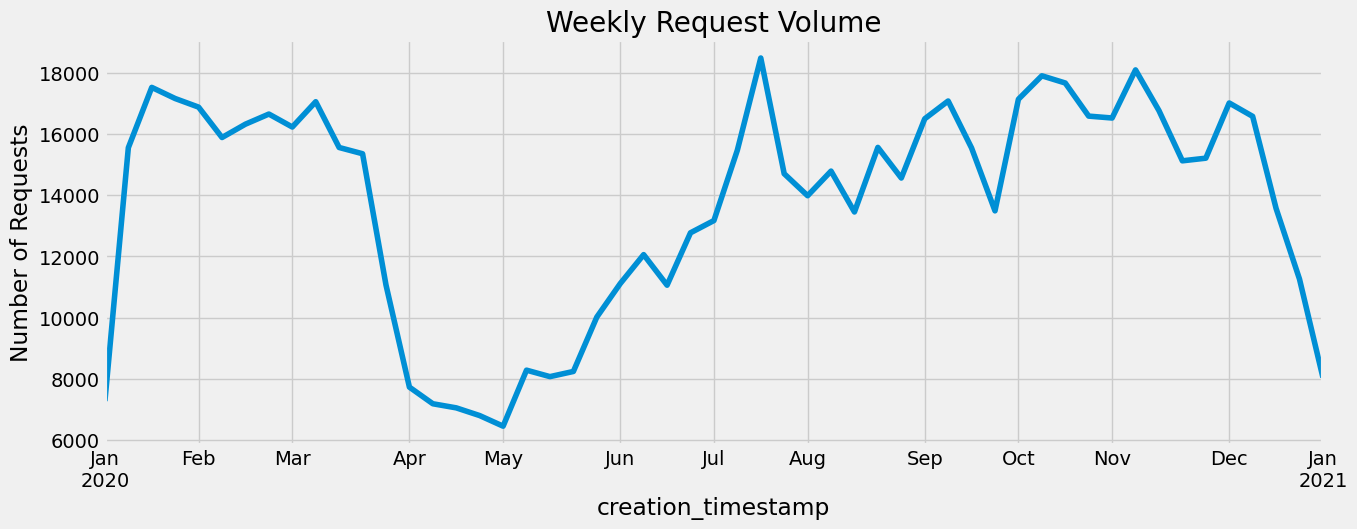

In [11]:
# Plot the data
plt.figure(figsize=(14,5))
df.set_index('creation_timestamp').resample('W').size().plot()
plt.title("Weekly Request Volume")
plt.ylabel("Number of Requests")
plt.show()

- steep drop during Covid lockdown and Christmas,  Steep increase in early January.  Spike in middle of July (?) 

In [13]:
# Request Type by Suburb
request_by_suburb = df.groupby(['official_suburb', 'code']).size().unstack(fill_value=0)
request_by_suburb.head().T

official_suburb,AAN DE WIJNLANDEN ESTATE,ACACIA PARK,ADMIRALS PARK,ADRIAANSE,AIRPORT
code,,,,,
AWS: Enquiry,0,0,0,0,0
AWS: Existing Installation,0,0,0,0,0
Abandoned Vehicles,0,0,1,0,0
Accident Damaged,0,0,0,0,0
Account Enquiries - Contact Centres only,0,0,0,0,0
...,...,...,...,...,...
Water Trough Defective,0,0,0,0,0
Water Trough Request,0,0,0,0,0
Water Turn on Supply Requested,0,0,0,0,0


<Axes: title={'center': 'Top Suburbs by Sewer: Blocked/Overflow Requests'}, ylabel='official_suburb'>

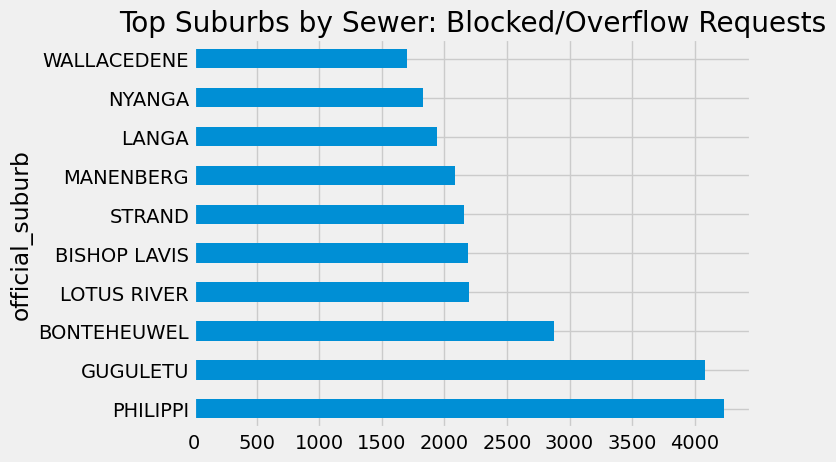

In [14]:
#Top 10 suburbs for request type Sewer: Blocked/Overflow

request_by_suburb['Sewer: Blocked/Overflow'].sort_values(ascending=False).head(10).plot(kind='barh', title='Top Suburbs by Sewer: Blocked/Overflow Requests')

<Axes: title={'center': 'Top Suburbs by No Power'}, ylabel='official_suburb'>

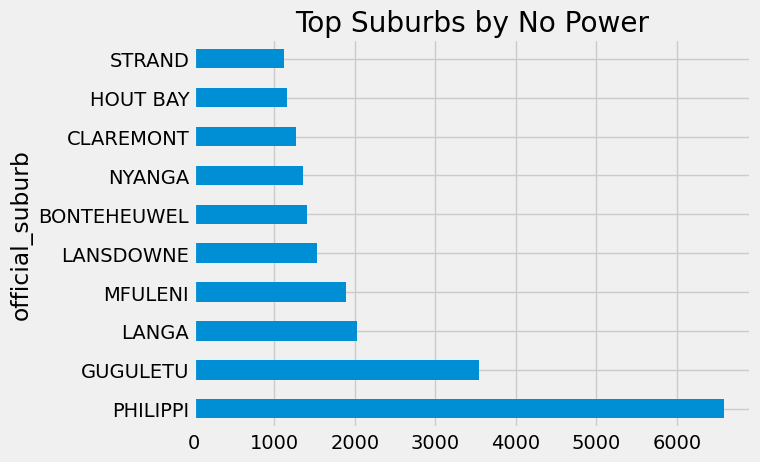

In [15]:
#Top 10 suburbs for request type No Power

request_by_suburb['No Power'].sort_values(ascending=False).head(10).plot(kind='barh', title='Top Suburbs by No Power')

<Axes: title={'center': 'Request Types in MOWBRAY'}, xlabel='code'>

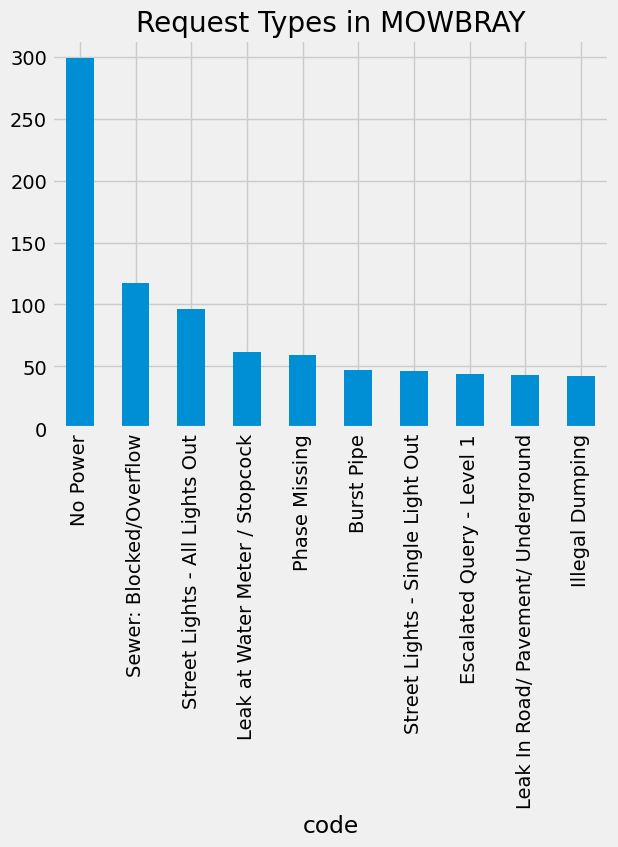

In [16]:
# Single request by suburb
request_by_suburb.loc['MOWBRAY'].sort_values(ascending=False).head(10).plot(kind='bar', title='Request Types in MOWBRAY')

num_schools and num_religious_sites correlate with request_count - these may be important features when we build the model  
There are a couple of features that correlate with each other, e.g. num_shops with num_pharmacies and num_banks - not a problem when building a tree based model. Is a problem when building a linear model.